Probe cell: z=148, x=43, y=49


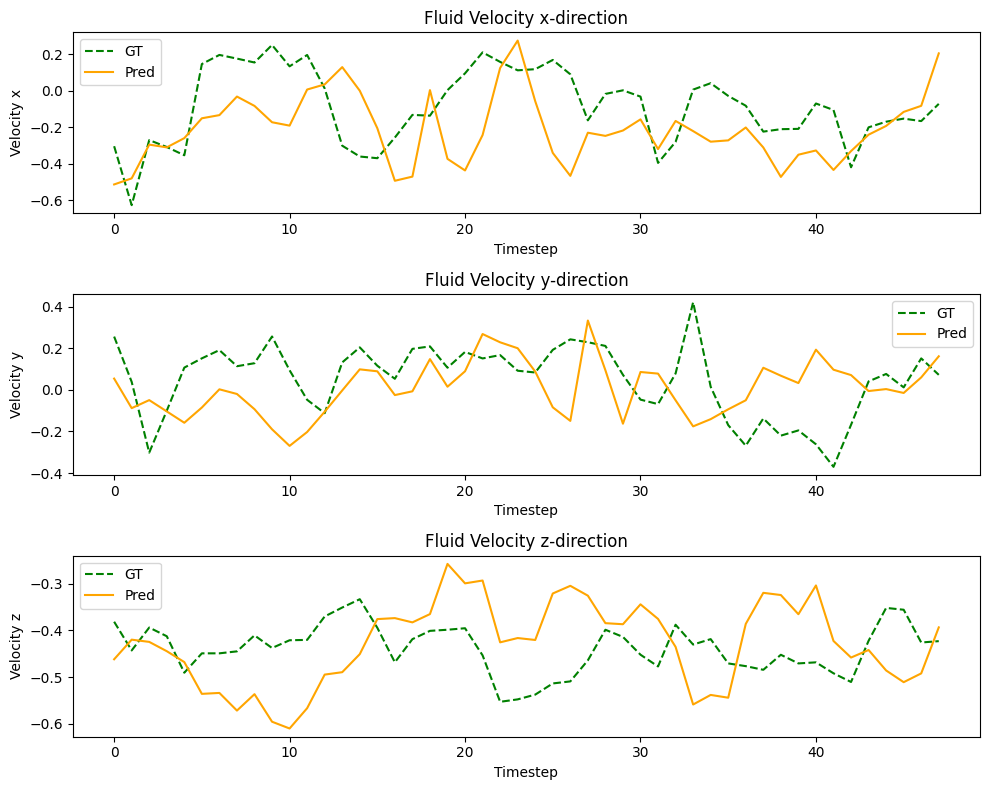

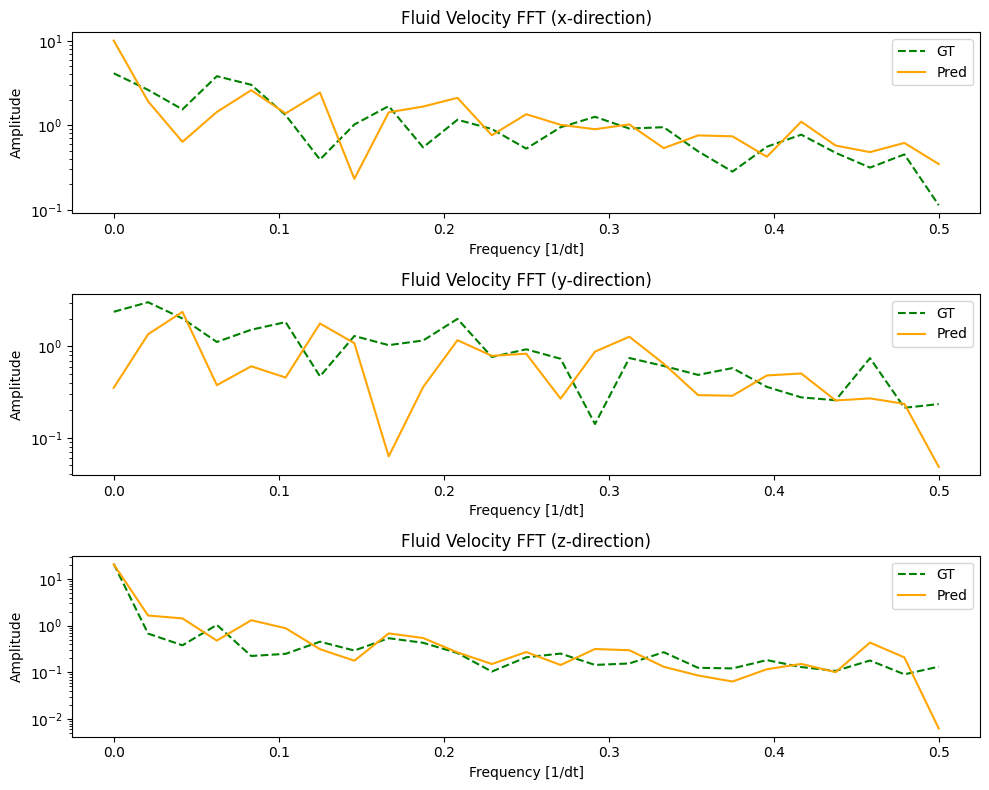

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os

os.chdir("/root/autodl-tmp/SCALED-Particle")

# -----------------------------
# Load Data
# -----------------------------
pred_files = sorted(glob.glob("exp/04_attn_sfc/rollout/npy/*.npy"))
pred_arrays = [np.load(f) for f in pred_files]  # (8,256,64,64)

gt_files = sorted(glob.glob("data/evaluation_npy_step200-250/*.npy"))
gt_arrays = [np.load(f) for f in gt_files]  # (8,256,64,64)

# -----------------------------
# Randomly select a probe cell
# -----------------------------
z_dim, x_dim, y_dim = gt_arrays[0].shape[1:]
z_idx = random.randint(0, z_dim - 1)
x_idx = random.randint(0, x_dim - 1)
y_idx = random.randint(0, y_dim - 1)
print(f"Probe cell: z={z_idx}, x={x_idx}, y={y_idx}")

# -----------------------------
# Extract fluid velocity time series
# -----------------------------
n_timesteps = len(pred_arrays)
fluid_vel_time = {0: [], 1: [], 2: []}  # x, y, z

for t in range(n_timesteps):
    gt = gt_arrays[t]
    pred = pred_arrays[t]

    for i in range(3):
        fluid_vel_time[i].append(
            (gt[i + 3, z_idx, x_idx, y_idx], pred[i + 3, z_idx, x_idx, y_idx])
        )


# -----------------------------
# Plot
# -----------------------------
def plot_fluid_velocity_timeseries(vel_time_dict):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    directions = ["x", "y", "z"]
    n_timesteps = len(next(iter(vel_time_dict.values())))

    for i in range(3):
        gt_series = [v[0] for v in vel_time_dict[i]]
        pred_series = [v[1] for v in vel_time_dict[i]]
        axes[i].plot(
            range(n_timesteps), gt_series, label="GT", color="green", linestyle="--"
        )
        axes[i].plot(range(n_timesteps), pred_series, label="Pred", color="orange")
        axes[i].set_xlabel("Timestep")
        axes[i].set_ylabel(f"Velocity {directions[i]}")
        axes[i].set_title(f"Fluid Velocity {directions[i]}-direction")
        axes[i].legend()

    plt.tight_layout()
    plt.savefig(f"result/vtfft/({z_idx}_{x_idx}_{y_idx})_fluid_velocity_.png")
    plt.show()


def plot_fluid_velocity_fft(vel_time_dict, dt=1.0):
    """
    Perform FFT on fluid velocity time series and plot the spectrum
    Parameters:
        vel_time_dict: dict, {0: [(gt, pred), ...], 1: [...], 2: [...]}
        dt: float, time step interval
    """
    directions = ["x", "y", "z"]
    n_timesteps = len(next(iter(vel_time_dict.values())))
    freqs = np.fft.rfftfreq(n_timesteps, d=dt)

    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    for i in range(3):
        gt_series = np.array([v[0] for v in vel_time_dict[i]])
        pred_series = np.array([v[1] for v in vel_time_dict[i]])

        # Fourier Transform
        fft_gt = np.fft.rfft(gt_series)
        fft_pred = np.fft.rfft(pred_series)

        # Magnitude Spectrum
        mag_gt = np.abs(fft_gt)
        mag_pred = np.abs(fft_pred)

        axes[i].plot(freqs, mag_gt, label="GT", color="green", linestyle="--")
        axes[i].plot(freqs, mag_pred, label="Pred", color="orange")
        axes[i].set_xlabel("Frequency [1/dt]")
        axes[i].set_ylabel("Amplitude")
        axes[i].set_title(f"Fluid Velocity FFT ({directions[i]}-direction)")
        axes[i].legend()
        axes[i].set_yscale("log")

    plt.tight_layout()
    plt.savefig(f"result/vtfft/({z_idx}_{x_idx}_{y_idx})_fluid_velocity_fft.png")
    plt.show()


os.makedirs("result/vtfft", exist_ok=True)
plot_fluid_velocity_timeseries(fluid_vel_time)
plot_fluid_velocity_fft(fluid_vel_time, dt=1.0)